<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DL_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torch
from torch.utils.data import random_split,DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

#1.0 Importing MNIST Dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [6]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#2.0 Defining Model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)


##2.1 Training

In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


##2.2 Testing

In [9]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [10]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [11]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

#3.0 Evaluation

In [12]:
lossfnc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


##3.1 Batch Gradient Decent

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 2.1695 | Train acc: 0.2836 | Test loss: 1.9939 | Test acc: 0.6591
Epoch: 2 | Train loss: 1.9995 | Train acc: 0.6539 | Test loss: 1.7867 | Test acc: 0.6916
Epoch: 3 | Train loss: 1.7965 | Train acc: 0.6832 | Test loss: 1.5528 | Test acc: 0.6894
Epoch: 4 | Train loss: 1.5662 | Train acc: 0.6792 | Test loss: 1.3194 | Test acc: 0.7480
Epoch: 5 | Train loss: 1.3346 | Train acc: 0.7472 | Test loss: 1.1201 | Test acc: 0.7709


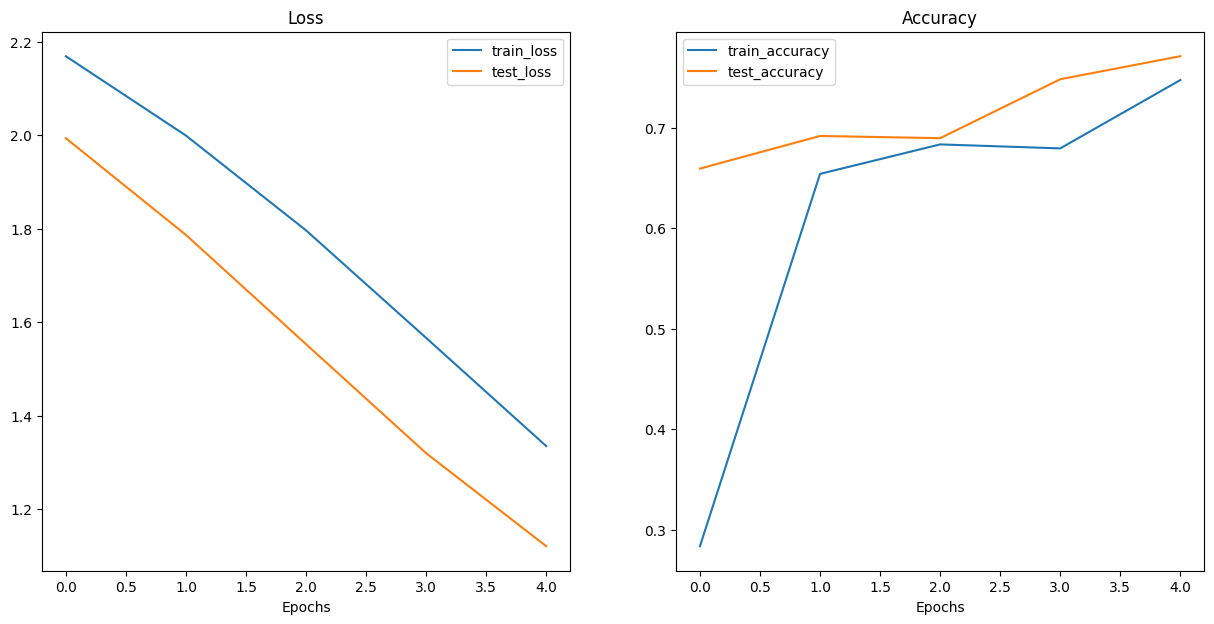

In [14]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
epochs = 5

batch_results = train(model, train_loader, test_loader, optimizer, lossfnc, epochs)
plot_loss_curves(batch_results)




##3.2 MiniBatch Gradient Decent

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.2642 | Train acc: 0.9178 | Test loss: 0.1536 | Test acc: 0.9524
Epoch: 2 | Train loss: 0.1312 | Train acc: 0.9592 | Test loss: 0.1151 | Test acc: 0.9637
Epoch: 3 | Train loss: 0.1020 | Train acc: 0.9684 | Test loss: 0.1015 | Test acc: 0.9696
Epoch: 4 | Train loss: 0.0838 | Train acc: 0.9734 | Test loss: 0.1052 | Test acc: 0.9668
Epoch: 5 | Train loss: 0.0704 | Train acc: 0.9777 | Test loss: 0.1083 | Test acc: 0.9666


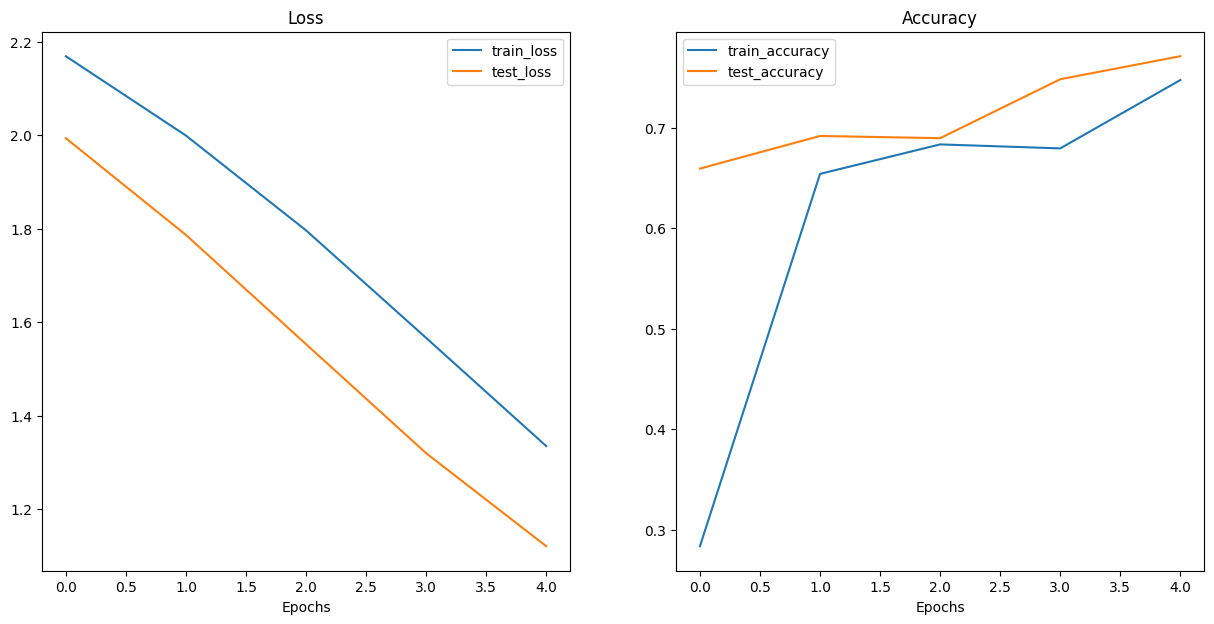

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

minibatch_results = train(model, train_loader, test_loader, optimizer, lossfnc, epochs)
plot_loss_curves(batch_results)

##3.3 Stochstic Gradient Decent

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.3967 | Train acc: 0.8964 | Test loss: 0.2678 | Test acc: 0.9240
Epoch: 2 | Train loss: 0.3195 | Train acc: 0.9242 | Test loss: 0.3156 | Test acc: 0.9305
Epoch: 3 | Train loss: 0.2864 | Train acc: 0.9312 | Test loss: 0.2653 | Test acc: 0.9292
Epoch: 4 | Train loss: 0.2838 | Train acc: 0.9345 | Test loss: 0.2973 | Test acc: 0.9378
Epoch: 5 | Train loss: 0.2791 | Train acc: 0.9376 | Test loss: 0.4530 | Test acc: 0.9229


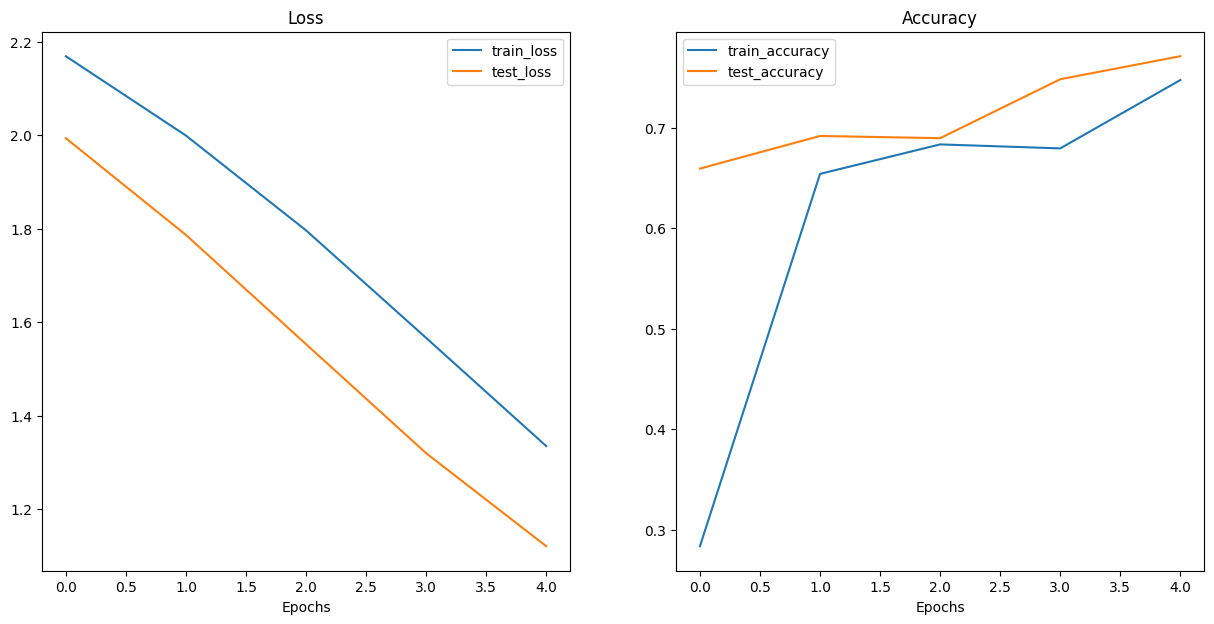

In [16]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

stochasticgd_results = train(model, train_loader, test_loader, optimizer, lossfnc, epochs)
plot_loss_curves(batch_results)